In [1]:
import sys
sys.path.append('/home/wangs/rs/lib')
import ff
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from multiprocessing import Pool
from tqdm import tqdm
import statsmodels.api as sm
from datetime import datetime
import mplfinance as mpf
from functools import partial
import matplotlib as mpl

动量效应所匹配的配置行为是基本面驱动的、中长期的机构投资者行为
而反转效应匹配的是短期股票低买高卖的行为，大多数股票在大部分时间都保持震荡走势

机构下单主要是在早盘活跃阶段，配置类交易信息含量比较高，具有动量效应

误判价格波动中跟风行为较多，具有反转效应

尾盘价格波动既具有跟风行为特征，还具有算法交易、指数调仓等为了满足
成交任务的被动交易特征，信息量较少，具有反转效应

In [2]:
stock_list = ff.read('close').index 
def morning_ret(n):
    try:
        data = ff.read_min(n)
    except:
        a = pd.Series(np.nan,index=ff.read_min('000001.SZ')['close'][ff.read_min('000001.SZ').index.str.endswith('15:00:00')].index)
        a.name = n
        return a
    morning_cut = data.rolling(window=60,closed='right').sum()
    vwap = morning_cut[morning_cut.index.str.endswith('10:30:00')].iloc[:,4:6]
    morning_vwap = vwap.iloc[:,1]/vwap.iloc[:,0]
    open_price = data['open'][data.index.str.endswith('09:31:00')]
    pre_close = data['close'][data.index.str.endswith('15:00:00')].shift(1)
    a = (morning_vwap.values - open_price.values)/pre_close
    a.name = n
    return a

In [3]:
with Pool(48) as p:
    res_lst = list(tqdm(p.imap(morning_ret, stock_list), total=len(stock_list)))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5541/5541 [00:32<00:00, 171.69it/s]


In [4]:
morning_ret_all = pd.DataFrame(res_lst)
morning_ret_all.columns = pd.to_datetime(morning_ret_all.columns).strftime('%Y%m%d')
morning_ret_all = morning_ret_all.loc[:,:'20240322']
factor_morning = morning_ret_all.rolling(window=5,closed = 'left',axis = 1).sum()
factor = factor_morning

In [18]:
import extend
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
sns.set_style("whitegrid")
sns.set_palette("Pastel1")
mpl.rc("font",family='Droid Sans Fallback',weight="bold")
mv = ff.read('total_mv').loc[factor.index,factor.columns]
factor_neu = extend.spread_reg(factor, mv, ind=True)

long normal
持仓模式： 普通模式
持仓周期： 5
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


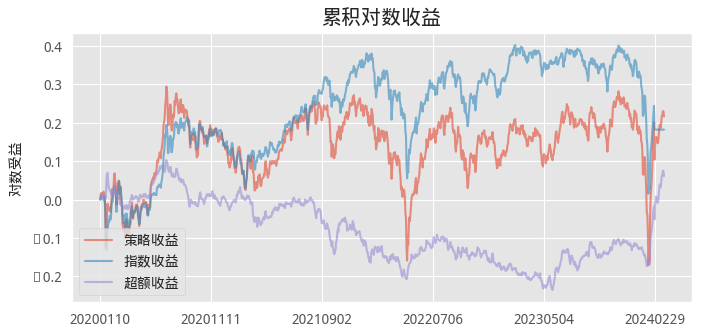

,指数收益,超额收益,策略收益
年化收益率,0.045,0.015,0.053
年化波动率,0.215,0.114,0.269
夏普率,0.208,0.131,0.197
最大回撤,-0.387,-0.338,-0.465
收益回撤比,0.116,0.044,0.114
胜率,0.520,0.479,0.518
盈亏比,0.956,1.111,0.960


(        指数收益   超额收益   策略收益
 年化收益率  0.045  0.015  0.053
 年化波动率  0.215  0.114  0.269
 夏普率    0.208  0.131  0.197
 最大回撤  -0.387 -0.338 -0.465
 收益回撤比  0.116  0.044  0.114
 胜率     0.520  0.479  0.518
 盈亏比    0.956  1.111  0.960,
                 策略     index          策略收益      指数收益      超额收益
 20200110  1.000000  1.000000  6.661338e-16  0.000000  0.000000
 20200113  1.016120  1.010176  1.599112e-02  0.010125  0.005926
 20200114  1.016615  1.010104  1.647887e-02  0.010053  0.006485
 20200115  1.014394  1.005413  1.429122e-02  0.005398  0.008941
 20200116  1.015425  1.001790  1.530720e-02  0.001789  0.013550
 ...            ...       ...           ...       ...       ...
 20240318  1.241602  1.199478  2.164024e-01  0.181886  0.061247
 20240319  1.243412  1.199478  2.178595e-01  0.181886  0.062705
 20240320  1.258620  1.199478  2.300158e-01  0.181886  0.074861
 20240321  1.257984  1.199478  2.295104e-01  0.181886  0.074356
 20240322  1.241199  1.199478  2.160781e-01  0.181886  0.060923
 
 [101

In [19]:
ff.run(factor_neu*(ff.filter0.iloc[:-1,:]), positions = 100, period = 5, fees = 0) 

早期收益因子改进：温和收益
提出假设，早盘收益需要‘温和’才能呈现动量效果
探索方案来划分温和收益和极值收益

第一种方案认为早盘中的涨幅如果过大，应该在当天的因子中体现一个相反的调仓的动作

long normal
持仓模式： 普通模式
持仓周期： 5
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


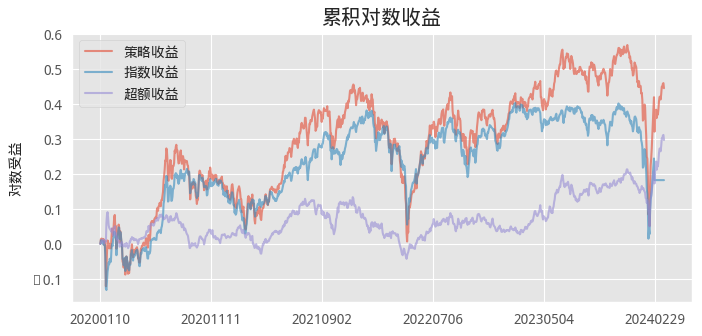

,指数收益,超额收益,策略收益
年化收益率,0.045,0.073,0.109
年化波动率,0.215,0.116,0.277
夏普率,0.208,0.628,0.394
最大回撤,-0.387,-0.176,-0.516
收益回撤比,0.116,0.414,0.212
胜率,0.520,0.515,0.548
盈亏比,0.956,1.047,0.883


(        指数收益   超额收益   策略收益
 年化收益率  0.045  0.073  0.109
 年化波动率  0.215  0.116  0.277
 夏普率    0.208  0.628  0.394
 最大回撤  -0.387 -0.176 -0.516
 收益回撤比  0.116  0.414  0.212
 胜率     0.520  0.515  0.548
 盈亏比    0.956  1.047  0.883,
                 策略     index          策略收益      指数收益      超额收益
 20200110  1.000000  1.000000  6.661338e-16  0.000000  0.000000
 20200113  1.013679  1.010176  1.358600e-02  0.010125  0.003496
 20200114  1.015246  1.010104  1.513129e-02  0.010053  0.005113
 20200115  1.014068  1.005413  1.397022e-02  0.005398  0.008591
 20200116  1.014291  1.001790  1.418937e-02  0.001789  0.012406
 ...            ...       ...           ...       ...       ...
 20240318  1.565572  1.199478  4.482512e-01  0.181886  0.300477
 20240319  1.563380  1.199478  4.468503e-01  0.181886  0.299076
 20240320  1.579039  1.199478  4.568162e-01  0.181886  0.309042
 20240321  1.581788  1.199478  4.585561e-01  0.181886  0.310781
 20240322  1.559119  1.199478  4.441208e-01  0.181886  0.296346
 
 [101

In [45]:
morning_ret_filter_reversion = (abs(morning_ret_all) > 0.02).replace({False:1,True:-1}) * morning_ret_all
factor_filter_reversion = morning_ret_filter_reversion.rolling(window=5,closed = 'left',axis = 1).sum()
factor_neu = extend.spread_reg(factor_filter_reversion, mv, ind=True)
ff.run(-factor_neu*(ff.filter0.iloc[:-1,:]), positions = 100, period = 5, fees = 0) 

long normal
持仓模式： 普通模式
持仓周期： 5
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


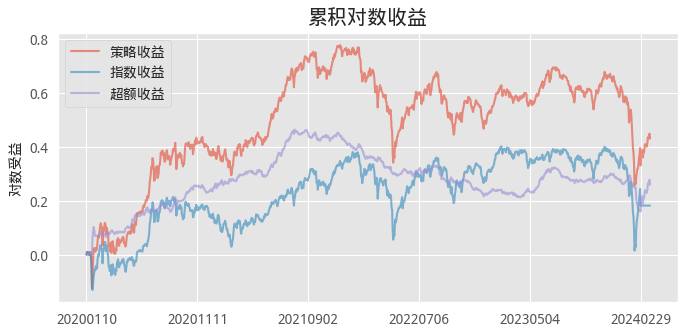

,指数收益,超额收益,策略收益
年化收益率,0.045,0.064,0.106
年化波动率,0.215,0.091,0.245
夏普率,0.208,0.704,0.433
最大回撤,-0.387,-0.304,-0.520
收益回撤比,0.116,0.210,0.204
胜率,0.520,0.504,0.547
盈亏比,0.956,1.118,0.892


(        指数收益   超额收益   策略收益
 年化收益率  0.045  0.064  0.106
 年化波动率  0.215  0.091  0.245
 夏普率    0.208  0.704  0.433
 最大回撤  -0.387 -0.304 -0.520
 收益回撤比  0.116  0.210  0.204
 胜率     0.520  0.504  0.547
 盈亏比    0.956  1.118  0.892,
                 策略     index          策略收益      指数收益      超额收益
 20200110  1.000000  1.000000  6.661338e-16  0.000000  0.000000
 20200113  1.009801  1.010176  9.753484e-03  0.010125 -0.000375
 20200114  1.008952  1.010104  8.912425e-03  0.010053 -0.001144
 20200115  1.006465  1.005413  6.444280e-03  0.005398  0.001032
 20200116  1.002562  1.001790  2.558400e-03  0.001789  0.000757
 ...            ...       ...           ...       ...       ...
 20240318  1.544830  1.199478  4.349140e-01  0.181886  0.263556
 20240319  1.536429  1.199478  4.294608e-01  0.181886  0.258103
 20240320  1.560568  1.199478  4.450501e-01  0.181886  0.273692
 20240321  1.566635  1.199478  4.489298e-01  0.181886  0.277572
 20240322  1.538824  1.199478  4.310183e-01  0.181886  0.259660
 
 [101

In [15]:
morning_ret_filter_ignore = (abs(morning_ret_all) > 0.02).replace({False:1,True:0}) * morning_ret_all
# morning_ret_filter_ignore = (abs(morning_ret_all) < 0.02).replace({False:np.nan,True:1}) * morning_ret_all
factor_filter_ignore = morning_ret_filter_ignore.rolling(window=5,closed = 'left',axis = 1).sum()
factor_neu = extend.spread_reg(factor_filter_ignore, mv, ind=True)
ff.run(-factor_neu*(ff.filter0.iloc[:-1,:]), positions = 100, period = 5, fees = 0) 

考虑每天的filter是用当天的波动状态作为基准

long normal
持仓模式： 普通模式
持仓周期： 5
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


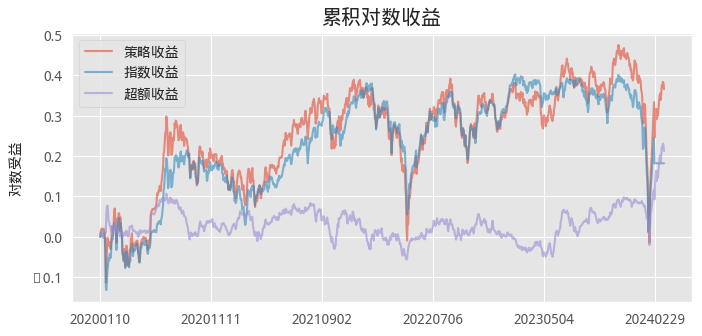

,指数收益,超额收益,策略收益
年化收益率,0.045,0.052,0.090
年化波动率,0.215,0.114,0.271
夏普率,0.208,0.457,0.331
最大回撤,-0.387,-0.163,-0.489
收益回撤比,0.116,0.320,0.184
胜率,0.520,0.500,0.533
盈亏比,0.956,1.082,0.927


(        指数收益   超额收益   策略收益
 年化收益率  0.045  0.052  0.090
 年化波动率  0.215  0.114  0.271
 夏普率    0.208  0.457  0.331
 最大回撤  -0.387 -0.163 -0.489
 收益回撤比  0.116  0.320  0.184
 胜率     0.520  0.500  0.533
 盈亏比    0.956  1.082  0.927,
                 策略     index          策略收益      指数收益      超额收益
 20200110  1.000000  1.000000  6.661338e-16  0.000000  0.000000
 20200113  1.015199  1.010176  1.508476e-02  0.010125  0.005010
 20200114  1.020743  1.010104  2.053067e-02  0.010053  0.010527
 20200115  1.019533  1.005413  1.934502e-02  0.005398  0.013980
 20200116  1.017081  1.001790  1.693680e-02  0.001789  0.015178
 ...            ...       ...           ...       ...       ...
 20240318  1.453367  1.199478  3.738826e-01  0.181886  0.220884
 20240319  1.450955  1.199478  3.722222e-01  0.181886  0.219223
 20240320  1.467407  1.199478  3.834972e-01  0.181886  0.230498
 20240321  1.464149  1.199478  3.812740e-01  0.181886  0.228275
 20240322  1.440908  1.199478  3.652736e-01  0.181886  0.212275
 
 [101

In [9]:
morning_ret_filter_cross = (abs(morning_ret_all) > ff.rets_all.mean()['20200102':'20240322']).replace({False:1,True:-1}) * morning_ret_all
factor_filter_cross = morning_ret_filter_cross.rolling(window=5,closed = 'left',axis = 1).sum()
factor_neu = extend.spread_reg(factor_filter_cross, mv, ind=True)
ff.run(-factor_neu*(ff.filter0.iloc[:-1,:]), positions = 100, period = 5, fees = 0) 

long normal
持仓模式： 普通模式
持仓周期： 20
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


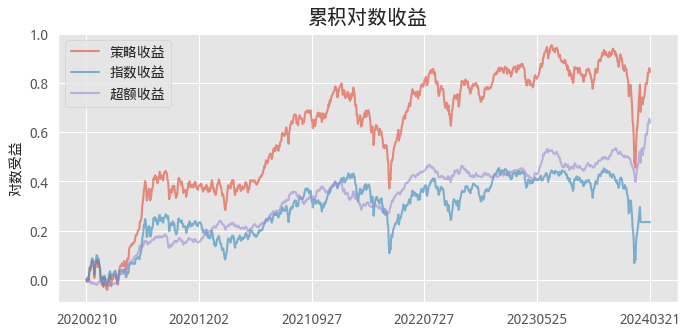

,指数收益,超额收益,策略收益
年化收益率,0.059,0.160,0.211
年化波动率,0.210,0.099,0.261
夏普率,0.279,1.604,0.808
最大回撤,-0.387,-0.138,-0.499
收益回撤比,0.151,1.157,0.423
胜率,0.521,0.536,0.559
盈亏比,0.964,1.150,0.906


(        指数收益   超额收益   策略收益
 年化收益率  0.059  0.160  0.211
 年化波动率  0.210  0.099  0.261
 夏普率    0.279  1.604  0.808
 最大回撤  -0.387 -0.138 -0.499
 收益回撤比  0.151  1.157  0.423
 胜率     0.521  0.536  0.559
 盈亏比    0.964  1.150  0.906,
                 策略     index          策略收益      指数收益      超额收益
 20200210  1.000000  1.000000  6.661338e-16  0.000000  0.000000
 20200211  0.990768  0.994574 -9.274454e-03 -0.005441 -0.003813
 20200212  1.004905  1.010518  4.893173e-03  0.010463 -0.005577
 20200213  0.995540  1.000783 -4.470363e-03  0.000782 -0.005263
 20200214  0.993960  1.002446 -6.058691e-03  0.002443 -0.008518
 ...            ...       ...           ...       ...       ...
 20240318  2.320209  1.264647  8.416571e-01  0.234793  0.635210
 20240319  2.316412  1.264647  8.400195e-01  0.234793  0.633572
 20240320  2.359093  1.264647  8.582774e-01  0.234793  0.651830
 20240321  2.367260  1.264647  8.617331e-01  0.234793  0.655286
 20240322  2.330131  1.264647  8.459244e-01  0.234793  0.639477
 
 [100

In [48]:
morning_ret_filter_reversion_20 = (abs(morning_ret_all) > 0.02).replace({False:1,True:-1}) * morning_ret_all
factor_filter_reversion_20 = morning_ret_filter_reversion_20.rolling(window=20,closed = 'left',axis = 1).sum()
factor_neu = extend.spread_reg(factor_filter_reversion_20, mv, ind=True)
ff.run(-factor_neu*(ff.filter0.iloc[:-1,:]), positions = 100, period = 20, fees = 0) 

long normal
持仓模式： 普通模式
持仓周期： 40
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


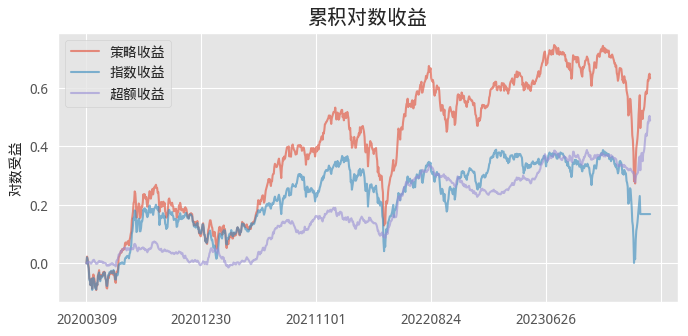

,指数收益,超额收益,策略收益
年化收益率,0.043,0.124,0.161
年化波动率,0.207,0.096,0.254
夏普率,0.207,1.291,0.633
最大回撤,-0.387,-0.110,-0.473
收益回撤比,0.111,1.127,0.340
胜率,0.519,0.522,0.547
盈亏比,0.958,1.154,0.922


(        指数收益   超额收益   策略收益
 年化收益率  0.043  0.124  0.161
 年化波动率  0.207  0.096  0.254
 夏普率    0.207  1.291  0.633
 最大回撤  -0.387 -0.110 -0.473
 收益回撤比  0.111  1.127  0.340
 胜率     0.519  0.522  0.547
 盈亏比    0.958  1.154  0.922,
                 策略     index          策略收益      指数收益      超额收益
 20200309  1.000000  1.000000  6.661338e-16  0.000000  0.000000
 20200310  1.023399  1.020914  2.312964e-02  0.020698  0.002482
 20200311  1.015514  1.012192  1.539454e-02  0.012118  0.003320
 20200312  0.997364  0.993569 -2.639069e-03 -0.006452  0.003846
 20200313  0.985299  0.982040 -1.480991e-02 -0.018123  0.003353
 ...            ...       ...           ...       ...       ...
 20240318  1.869167  1.183441  6.254931e-01  0.168426  0.481356
 20240319  1.864768  1.183441  6.231364e-01  0.168426  0.478999
 20240320  1.901675  1.183441  6.427353e-01  0.168426  0.498598
 20240321  1.911663  1.183441  6.479735e-01  0.168426  0.503836
 20240322  1.881426  1.183441  6.320300e-01  0.168426  0.487892
 
 [982

In [42]:
morning_ret_filter_reversion_40 = (abs(morning_ret_all) > 0.02).replace({False:1,True:-1}) * morning_ret_all
factor_filter_reversion_40 = morning_ret_filter_reversion_40.rolling(window=40,closed = 'left',axis = 1).sum()
factor_neu = extend.spread_reg(factor_filter_reversion_40, mv, ind=True)
ff.run(-factor_neu*(ff.filter0.iloc[:-1,:]), positions = 100, period = 40, fees = 0) 

In [39]:
def noon_ret(n):
    try:
        data = ff.read_min(n)
    except:
        a = pd.Series(np.nan,index=ff.read_min('000001.SZ')['close'][ff.read_min('000001.SZ').index.str.endswith('15:00:00')].index)
        a.name = n
        return a
    morning_cut = data.rolling(window=60,closed='right').sum()
    vwap = morning_cut[morning_cut.index.str.endswith('10:30:00')].iloc[:,4:6]
    morning_vwap = vwap.iloc[:,1]/vwap.iloc[:,0]
    noon_cut = data.rolling(window=150,closed='right').sum()
    vwap = noon_cut[noon_cut.index.str.endswith('14:30:00')].iloc[:,4:6]
    noon_vwap = vwap.iloc[:,1]/vwap.iloc[:,0]
    pre_close = data['close'][data.index.str.endswith('15:00:00')].shift(1)
    a = (noon_vwap.values - morning_vwap.values)/pre_close
    a.name = n
    return a

In [23]:
with Pool(48) as p:
    res_lst = list(tqdm(p.imap(noon_ret, stock_list), total=len(stock_list)))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5531/5531 [00:35<00:00, 153.95it/s]


In [24]:
noon_ret_all = pd.DataFrame(res_lst)
noon_ret_all.columns = pd.to_datetime(noon_ret_all.columns).strftime('%Y%m%d')
noon_ret_all = noon_ret_all.loc[:,:'20240322']
factor_noon = -noon_ret_all.rolling(window=5,closed = 'left',axis = 1).sum()

long normal
持仓模式： 普通模式
持仓周期： 5
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


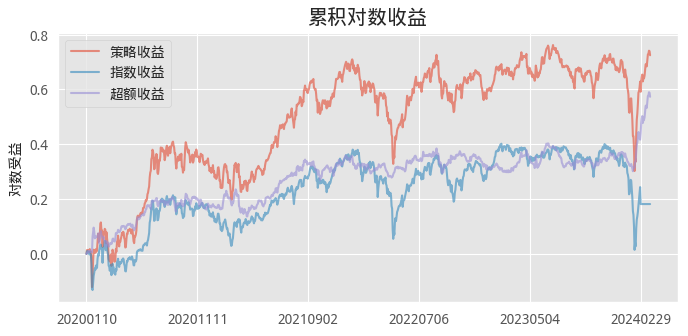

,指数收益,超额收益,策略收益
年化收益率,0.045,0.141,0.178
年化波动率,0.215,0.128,0.279
夏普率,0.208,1.100,0.639
最大回撤,-0.387,-0.102,-0.459
收益回撤比,0.116,1.386,0.388
胜率,0.520,0.515,0.545
盈亏比,0.956,1.139,0.931


(        指数收益   超额收益   策略收益
 年化收益率  0.045  0.141  0.178
 年化波动率  0.215  0.128  0.279
 夏普率    0.208  1.100  0.639
 最大回撤  -0.387 -0.102 -0.459
 收益回撤比  0.116  1.386  0.388
 胜率     0.520  0.515  0.545
 盈亏比    0.956  1.139  0.931,
                 策略     index          策略收益      指数收益      超额收益
 20200110  1.000000  1.000000  6.661338e-16  0.000000  0.000000
 20200113  1.014271  1.010176  1.417018e-02  0.010125  0.004086
 20200114  1.014351  1.010104  1.424872e-02  0.010053  0.004237
 20200115  1.012662  1.005413  1.258230e-02  0.005398  0.007211
 20200116  1.013170  1.001790  1.308365e-02  0.001789  0.011307
 ...            ...       ...           ...       ...       ...
 20240318  2.069992  1.199478  7.275447e-01  0.181886  0.576099
 20240319  2.074778  1.199478  7.298541e-01  0.181886  0.578409
 20240320  2.098179  1.199478  7.410697e-01  0.181886  0.589624
 20240321  2.094233  1.199478  7.391873e-01  0.181886  0.587742
 20240322  2.063824  1.199478  7.245604e-01  0.181886  0.573115
 
 [101

In [25]:
factor_neu = extend.spread_reg(factor_noon, mv, ind=True)
ff.run(-factor_neu*(ff.filter0.iloc[:-1,:]), positions = 100, period = 5, fees = 0) 

In [11]:
def tail_ret(n):
    try:
        data = ff.read_min(n)
    except:
        a = pd.Series(np.nan,index=ff.read_min('000001.SZ')['close'][ff.read_min('000001.SZ').index.str.endswith('15:00:00')].index)
        a.name = n
        return a
    noon_cut = data.rolling(window=150,closed='right').sum()
    vwap = noon_cut[noon_cut.index.str.endswith('14:30:00')].iloc[:,4:6]
    noon_vwap = vwap.iloc[:,1]/vwap.iloc[:,0]
    close = data['close'][data.index.str.endswith('15:00:00')]
    pre_close = data['close'][data.index.str.endswith('15:00:00')].shift(1)
    a = (close.values - noon_vwap.values)/pre_close
    a.name = n
    return a

In [12]:
with Pool(48) as p:
    res_lst = list(tqdm(p.imap(tail_ret, stock_list), total=len(stock_list)))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5531/5531 [00:32<00:00, 169.56it/s]


In [13]:
tail_ret_all = pd.DataFrame(res_lst)
tail_ret_all.columns = pd.to_datetime(tail_ret_all.columns).strftime('%Y%m%d')
tail_ret_all = tail_ret_all.loc[:,:'20240322']
factor_tail = (-tail_ret_all).rolling(window=5,closed = 'left',axis = 1).sum()

long normal
持仓模式： 普通模式
持仓周期： 5
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


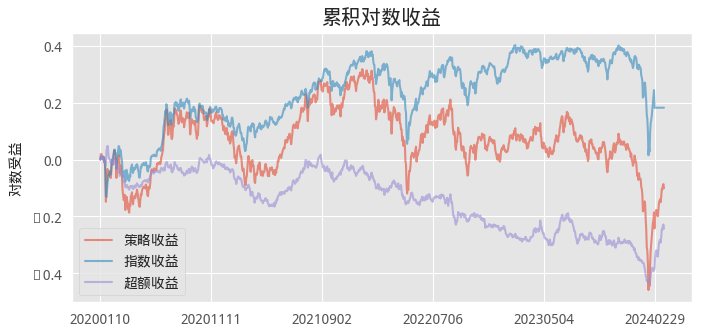

,指数收益,超额收益,策略收益
年化收益率,0.045,-0.060,-0.025
年化波动率,0.215,0.127,0.287
夏普率,0.208,-0.471,-0.086
最大回撤,-0.387,-0.482,-0.775
收益回撤比,0.116,-0.124,-0.032
胜率,0.520,0.490,0.515
盈亏比,0.956,0.962,0.925


(        指数收益   超额收益   策略收益
 年化收益率  0.045 -0.060 -0.025
 年化波动率  0.215  0.127  0.287
 夏普率    0.208 -0.471 -0.086
 最大回撤  -0.387 -0.482 -0.775
 收益回撤比  0.116 -0.124 -0.032
 胜率     0.520  0.490  0.515
 盈亏比    0.956  0.962  0.925,
                 策略     index          策略收益      指数收益      超额收益
 20200110  1.000000  1.000000  6.661338e-16  0.000000  0.000000
 20200113  1.019261  1.010176  1.907783e-02  0.010125  0.009044
 20200114  1.019533  1.010104  1.934495e-02  0.010053  0.009382
 20200115  1.009456  1.005413  9.411088e-03  0.005398  0.004128
 20200116  1.012721  1.001790  1.264056e-02  0.001789  0.010943
 ...            ...       ...           ...       ...       ...
 20240318  0.901578  1.199478 -1.036091e-01  0.181886 -0.245458
 20240319  0.899590  1.199478 -1.058164e-01  0.181886 -0.247665
 20240320  0.912706  1.199478 -9.134102e-02  0.181886 -0.233190
 20240321  0.917362  1.199478 -8.625284e-02  0.181886 -0.228102
 20240322  0.904048  1.199478 -1.008732e-01  0.181886 -0.242722
 
 [101

In [20]:
factor_neu = extend.spread_reg(factor_tail, mv, ind=True)
ff.run(-factor_neu*(ff.filter0.iloc[:-1,:]), positions = 100, period = 5, fees = 0) 

In [31]:
factor_morning_close = (-tail_ret_all).rolling(window=5,closed = 'left',axis = 1).sum() + (-noon_ret_all).rolling(window=20,closed = 'left',axis = 1).sum()

long normal
持仓模式： 普通模式
持仓周期： 5
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


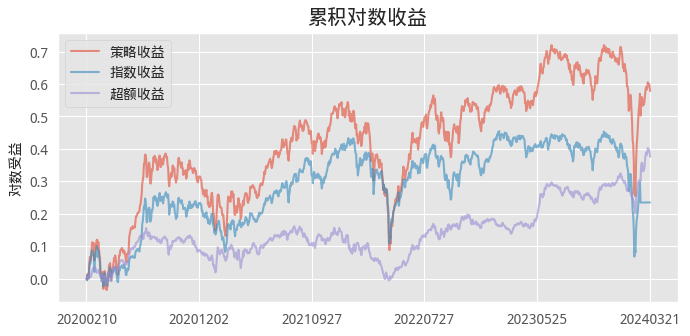

,指数收益,超额收益,策略收益
年化收益率,0.059,0.094,0.144
年化波动率,0.210,0.114,0.271
夏普率,0.279,0.826,0.533
最大回撤,-0.387,-0.167,-0.466
收益回撤比,0.151,0.561,0.309
胜率,0.521,0.518,0.537
盈亏比,0.964,1.067,0.942


(        指数收益   超额收益   策略收益
 年化收益率  0.059  0.094  0.144
 年化波动率  0.210  0.114  0.271
 夏普率    0.279  0.826  0.533
 最大回撤  -0.387 -0.167 -0.466
 收益回撤比  0.151  0.561  0.309
 胜率     0.521  0.518  0.537
 盈亏比    0.964  1.067  0.942,
                 策略     index          策略收益      指数收益      超额收益
 20200210  1.000000  1.000000  6.661338e-16  0.000000  0.000000
 20200211  0.996977  0.994574 -3.027340e-03 -0.005441  0.002400
 20200212  1.014871  1.010518  1.476168e-02  0.010463  0.004315
 20200213  1.001241  1.000783  1.240214e-03  0.000782  0.000512
 20200214  1.001698  1.002446  1.696243e-03  0.002443 -0.000695
 ...            ...       ...           ...       ...       ...
 20240318  1.832211  1.264647  6.055234e-01  0.234793  0.403112
 20240319  1.815033  1.264647  5.961038e-01  0.234793  0.393692
 20240320  1.822766  1.264647  6.003549e-01  0.234793  0.397943
 20240321  1.813398  1.264647  5.952025e-01  0.234793  0.392791
 20240322  1.783261  1.264647  5.784436e-01  0.234793  0.376032
 
 [100

In [32]:
factor_neu = extend.spread_reg(factor_morning_close, mv, ind=True)
ff.run(-factor_neu*(ff.filter0.iloc[:-1,:]), positions = 100, period = 5, fees = 0) 

In [34]:
factor_morning_close_big = factor_morning_close[factor_morning_close > factor_morning_close.quantile(0.8).replace({True:1,False:np.nan})]

long normal
持仓模式： 普通模式
持仓周期： 5
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


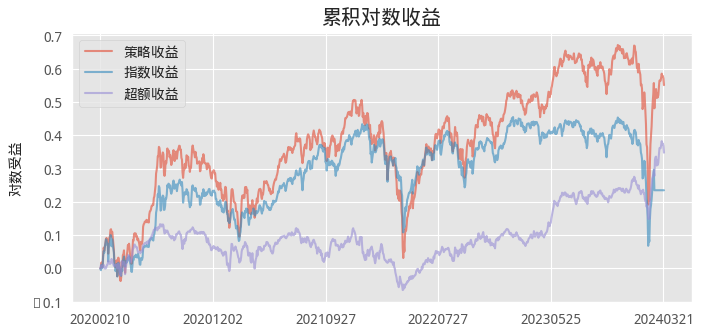

,指数收益,超额收益,策略收益
年化收益率,0.059,0.087,0.137
年化波动率,0.210,0.127,0.276
夏普率,0.279,0.683,0.498
最大回撤,-0.387,-0.198,-0.480
收益回撤比,0.151,0.439,0.287
胜率,0.521,0.512,0.538
盈亏比,0.964,1.068,0.935


(        指数收益   超额收益   策略收益
 年化收益率  0.059  0.087  0.137
 年化波动率  0.210  0.127  0.276
 夏普率    0.279  0.683  0.498
 最大回撤  -0.387 -0.198 -0.480
 收益回撤比  0.151  0.439  0.287
 胜率     0.521  0.512  0.538
 盈亏比    0.964  1.068  0.935,
                 策略     index          策略收益      指数收益      超额收益
 20200210  1.000000  1.000000  6.661338e-16  0.000000  0.000000
 20200211  1.003572  0.994574  3.565499e-03 -0.005441  0.008957
 20200212  1.017802  1.010518  1.764540e-02  0.010463  0.007104
 20200213  1.004502  1.000783  4.492219e-03  0.000782  0.003665
 20200214  1.004911  1.002446  4.898906e-03  0.002443  0.002409
 ...            ...       ...           ...       ...       ...
 20240318  1.795298  1.264647  5.851710e-01  0.234793  0.382155
 20240319  1.779309  1.264647  5.762250e-01  0.234793  0.373209
 20240320  1.782568  1.264647  5.780549e-01  0.234793  0.375039
 20240321  1.770673  1.264647  5.713598e-01  0.234793  0.368344
 20240322  1.734569  1.264647  5.507590e-01  0.234793  0.347743
 
 [100

In [37]:
factor_neu = extend.spread_reg(factor_morning_close_big, mv, ind=True)
ff.run(-factor_neu*(ff.filter0.iloc[:-1,:]), positions = 100, period = 5, fees = 0) 

In [49]:
factor_mom_spring = factor_filter_reversion_20 + factor_morning_close

long normal
持仓模式： 普通模式
持仓周期： 5
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


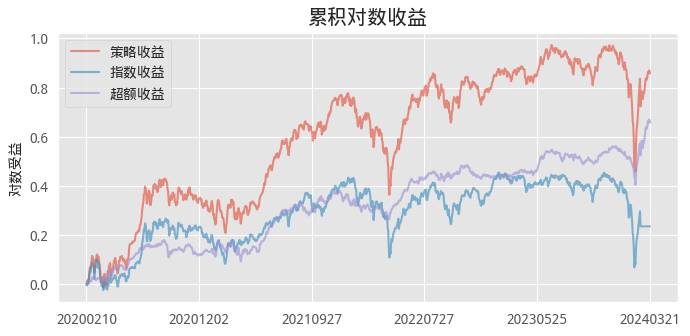

,指数收益,超额收益,策略收益
年化收益率,0.059,0.164,0.214
年化波动率,0.210,0.117,0.275
夏普率,0.279,1.405,0.779
最大回撤,-0.387,-0.158,-0.515
收益回撤比,0.151,1.039,0.415
胜率,0.521,0.526,0.557
盈亏比,0.964,1.153,0.909


(        指数收益   超额收益   策略收益
 年化收益率  0.059  0.164  0.214
 年化波动率  0.210  0.117  0.275
 夏普率    0.279  1.405  0.779
 最大回撤  -0.387 -0.158 -0.515
 收益回撤比  0.151  1.039  0.415
 胜率     0.521  0.526  0.557
 盈亏比    0.964  1.153  0.909,
                 策略     index          策略收益      指数收益      超额收益
 20200210  1.000000  1.000000  6.661338e-16  0.000000  0.000000
 20200211  0.999230  0.994574 -7.702911e-04 -0.005441  0.004645
 20200212  1.017442  1.010518  1.729186e-02  0.010463  0.006838
 20200213  1.007187  1.000783  7.161458e-03  0.000782  0.006393
 20200214  1.008069  1.002446  8.037007e-03  0.002443  0.005606
 ...            ...       ...           ...       ...       ...
 20240318  2.367828  1.264647  8.619730e-01  0.234793  0.662196
 20240319  2.358358  1.264647  8.579657e-01  0.234793  0.658189
 20240320  2.385498  1.264647  8.694080e-01  0.234793  0.669631
 20240321  2.382981  1.264647  8.683521e-01  0.234793  0.668575
 20240322  2.356624  1.264647  8.572301e-01  0.234793  0.657453
 
 [100

In [50]:
factor_neu = extend.spread_reg(factor_mom_spring, mv, ind=True)
ff.run(-factor_neu*(ff.filter0.iloc[:-1,:]), positions = 100, period = 5, fees = 0) 